In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_debug_nans", True)

In [3]:
import os

from tqdm import trange, tqdm

import numpy as np
from scipy.stats import sem

import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from modules.diagnostics.visualizers import visualize_forecast_horizon_accuracy, visualize_time_series, visualize_time_series_components_performance
from modules.diagnostics.metrics import compute_rmse, compute_symmetric_absolute_percentage_error
from modules.data_handling.data_splitters import split_time_series_df, tabularize_time_series, expanding_split_time_series_df


# Constants

Here we will define constants that will be used acrossed the notebook

In [4]:
TRAINING_END_DATE = "2016-01-01"

DATA_FOLDER = "data"
GHI_FILE = "irradiance.csv"
WEATHER_FORECAST_FILES = [
    "nam_lat38.579454_lon121.260320.csv",
    "nam_lat38.599891_lon121.126680.csv",
    "nam_lat38.704328_lon121.152788.csv",
    "nam_lat38.683880_lon121.286556.csv"

]
SATELLITE_FILE = "satellite.csv"

# Data Loading

In this first section we will focus on loading the data dn conducting very preliminary data manipulation operations. Further data processing will be conducted in a second moment.

## GHI Data

From Wikipedia about GHI:

*Global horizontal irradiance (GHI) is the total irradiance from the Sun on a horizontal surface on Earth. It is the sum of direct irradiance (after accounting for the solar zenith angle of the Sun z) and diffuse horizontal irradiance*

$$GHI = DHI + DNI × cos ⁡ ( z ) {\displaystyle {\text{GHI}}={\text{DHI}}+{\text{DNI}}\times \cos(z)}$$

In [5]:
ghi_df = pd.read_csv(os.path.join(DATA_FOLDER, GHI_FILE), parse_dates=["timeStamp"])
# We ensure ghi data are continuous
idx = pd.date_range(ghi_df["timeStamp"].min(), ghi_df["timeStamp"].max(), freq="1min")
ghi_df = ghi_df.set_index("timeStamp") 
ghi_df = (
    ghi_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("linear")
)

ghi_df = (
    ghi_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

## Weather Forecast 

In [7]:
weather_df = []
for weather_forecast_file in WEATHER_FORECAST_FILES:
    
    weather_df.append(
        pd.read_csv(os.path.join(DATA_FOLDER, weather_forecast_file), parse_dates=["reftime", "valtime"])
        .dropna()
    )
    
weather_df = (
    pd.concat(weather_df, ignore_index=True)
    .groupby(
        [
            "reftime",
            "valtime"
        ]
    )
    .median()
    .reset_index()
)

## Satellite Images (black and white)

These specifically are GOES-15 images which according to wikipedia are black and white images produced by geosptial satellite. In our case the 10x10 format highlight the low resolution of the image.

In [8]:
satellite_df = pd.read_csv(os.path.join(DATA_FOLDER, SATELLITE_FILE), header=None, parse_dates=[0])
idx = pd.date_range(satellite_df[0].min(), satellite_df[0].max(), freq="15min")
satellite_df = satellite_df.set_index(0) 
satellite_df = (
    satellite_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("nearest")
)

satellite_df = (
    satellite_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

# Data Exploration

## GHI Data

In [9]:
ghi_df.describe()

,time,ghi,dni,dhi
count,1575360,1.575360e+06,1.575360e+06,1.575360e+06
mean,2015-07-03 07:59:30.000004096,2.054944e+02,2.560642e+02,5.345318e+01
min,2014-01-02 08:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2014-10-02 19:59:45,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015-07-03 07:59:30,1.280000e+00,0.000000e+00,2.509500e+00
75%,2016-04-01 19:59:15,3.788000e+02,6.538000e+02,7.873000e+01
max,2016-12-31 07:59:00,1.466000e+03,1.004000e+03,7.481000e+02
std,NaN,2.942295e+02,3.618388e+02,8.394639e+01


In [10]:
ghi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575360 entries, 0 to 1575359
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1575360 non-null  datetime64[ns]
 1   ghi     1575360 non-null  float64       
 2   dni     1575360 non-null  float64       
 3   dhi     1575360 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 48.1 MB


In [11]:
# Very relevant
ghi_df["month"] = ghi_df["time"].dt.month
ghi_df["day_year"] = ghi_df["time"].dt.day_of_year
ghi_df["hour"] = ghi_df["time"].dt.hour

# Spurious, these should come out irrelevant if there is no bias in the measurement
ghi_df["year"] = ghi_df["time"].dt.year
ghi_df["day_week"] = ghi_df["time"].dt.day_of_week
ghi_df["minute"] = ghi_df["time"].dt.minute

In [12]:
# We execpt at least 525600 datapoints if data are recorded continuously for 3 years
(
    ghi_df
    .groupby("year")
    .size()
)

year
2014    523680
2015    525600
2016    526080
dtype: int64

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

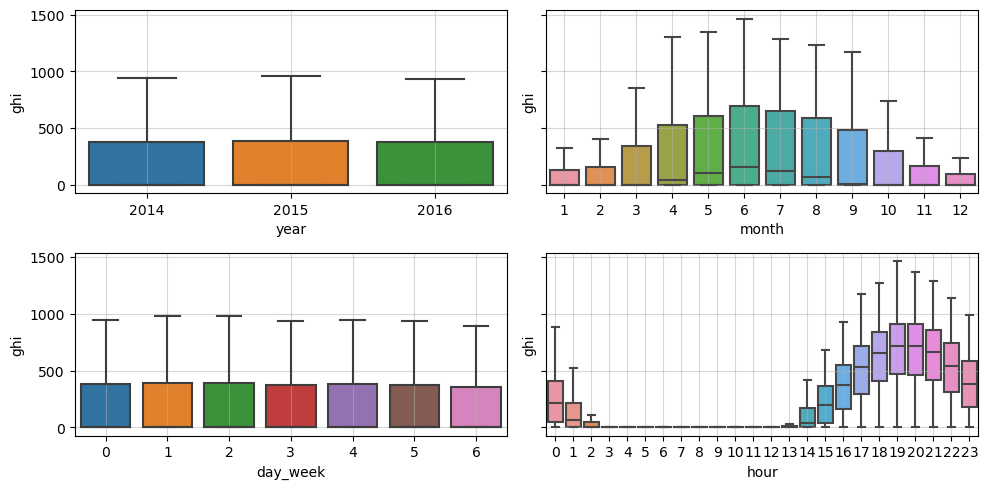

In [13]:
groupers = [
    "year",
    "month",
    "day_week",
    "hour"
]
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

for ax, grouper in zip(axs.flatten(), groupers):

    sns.boxplot(
        data=ghi_df,
        x=grouper,
        y="ghi",
        showfliers=False,
        ax=ax
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

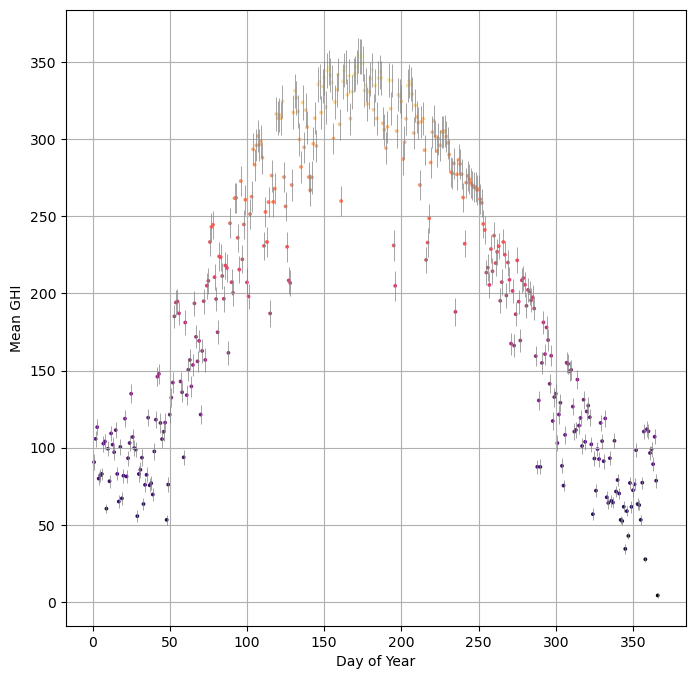

In [14]:
dayly_stats = (
    ghi_df
    .groupby("day_year")
    .agg(
        mean=("ghi", "mean"),
        std_err_mean=("ghi", lambda x: sem(x))
    )
    .reset_index()
    
)

plt.figure(figsize=(8, 8))
plt.scatter(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    s=3,
    c=dayly_stats["mean"].values,
    cmap="magma"
)
plt.errorbar(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    yerr=dayly_stats["std_err_mean"].values * 1.96,
    linewidth=0.5,
    ls='none',
    c="grey"

)
plt.ylabel("Mean GHI")
plt.xlabel("Day of Year")
plt.grid()

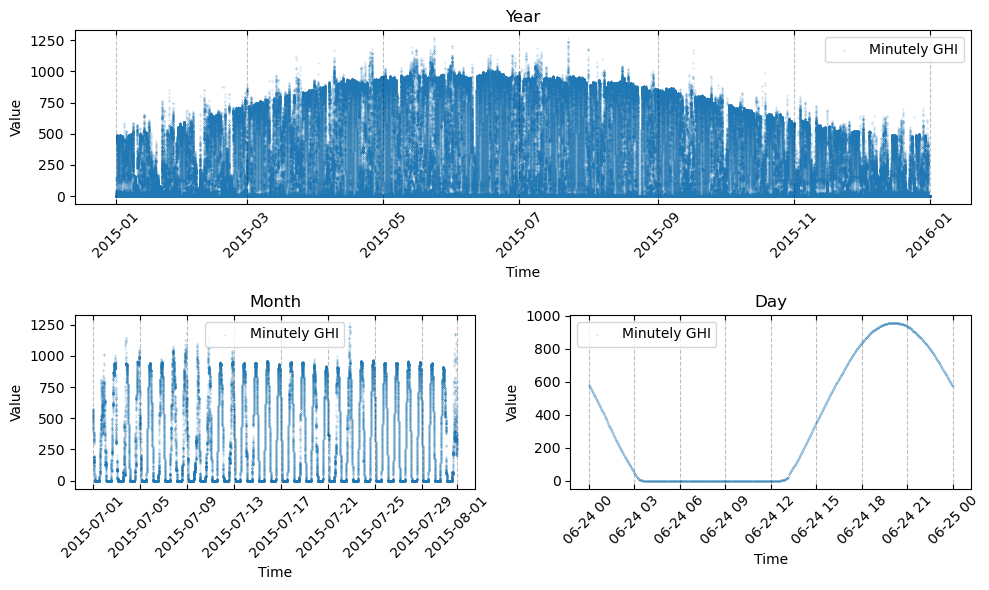

In [15]:
single_year_ghi_df = ghi_df[ghi_df["year"] == 2015]
single_month_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["month"] == 7)]
single_day_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["day_year"] == 175)]

fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax_year = fig.add_subplot(gs[0, :])
ax_month = fig.add_subplot(gs[1, 0])
ax_day = fig.add_subplot(gs[1, 1])


axes_dfs = {
   "Year": (ax_year, single_year_ghi_df),
   "Month": (ax_month, single_month_ghi_df),
   "Day": (ax_day, single_day_ghi_df)

}

for title, (ax, df) in axes_dfs.items():

    ax = visualize_time_series(
        ax=ax,
        time_series_name="Minutely GHI",
        time_series=df.set_index("time")["ghi"],
        s=0.05,
        alpha=0.5
    )
    ax.set_title(title)
    ax.legend()

## Satellite Data

In [16]:
satellite_df.head(5)

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2014-03-13 18:00:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
1,2014-03-13 18:15:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
2,2014-03-13 18:30:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
3,2014-03-13 18:45:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
4,2014-03-13 19:00:00,81.0,80.0,79.0,78.0,86.0,81.0,83.0,80.0,68.0,...,78.0,79.0,78.0,76.0,79.0,79.0,79.0,79.0,80.0,81.0


In [17]:
satellite_df.describe()

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,98327,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,...,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000
mean,2015-08-07 20:45:00.000000512,104.673986,104.354572,104.089691,103.965279,104.878446,104.323492,103.427512,103.123059,102.464542,...,104.924680,105.412308,105.496273,105.406287,106.677362,107.025151,107.638289,108.432760,109.142657,109.312457
min,2014-03-13 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-11-24 19:22:30,82.000000,81.000000,81.000000,80.000000,82.000000,82.000000,81.000000,80.000000,79.000000,...,82.000000,83.000000,83.000000,83.000000,85.000000,85.000000,86.000000,88.000000,89.000000,89.000000
50%,2015-08-07 20:45:00,95.000000,94.000000,94.000000,93.000000,95.000000,95.000000,95.000000,95.000000,93.000000,...,95.000000,95.000000,96.000000,96.000000,97.000000,97.000000,98.000000,99.000000,100.000000,101.000000
75%,2016-04-19 22:07:30,117.000000,117.000000,117.000000,116.000000,116.000000,116.000000,115.000000,115.000000,115.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,118.000000,118.000000,119.000000,119.000000
max,2016-12-31 23:30:00,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
std,NaN,31.515204,31.803811,31.878095,32.076861,31.736400,32.138111,32.745757,32.914638,33.090754,...,31.432413,31.217330,31.298630,31.428878,30.567715,30.247307,29.893872,29.529785,29.328337,29.243425


In [18]:
satellite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Columns: 101 entries, time to 100
dtypes: datetime64[ns](1), float64(100)
memory usage: 75.8 MB


In [19]:
satellite_df["year"] = satellite_df["time"].dt.year
(
    satellite_df
    .groupby("year")
    .size()
)

year
2014    28152
2015    35040
2016    35135
dtype: int64

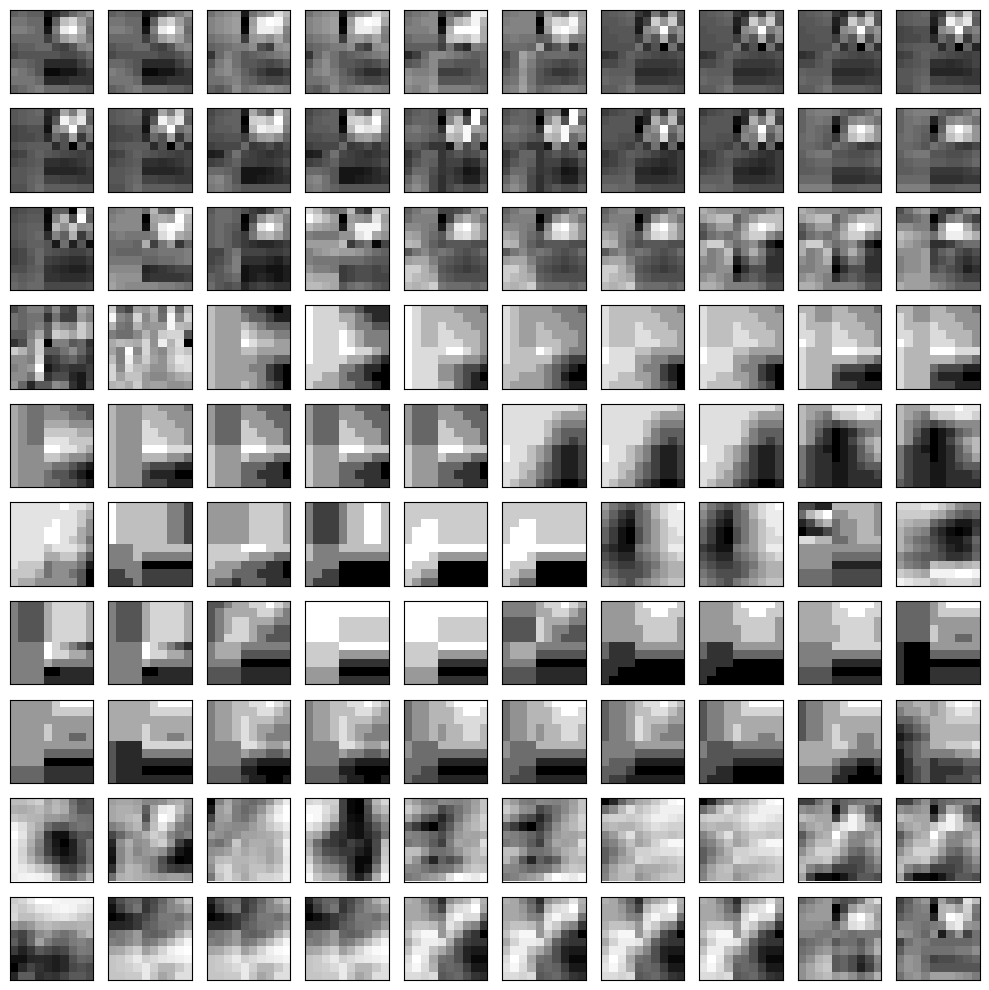

In [20]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=True)

for row, ax in enumerate(axs.flatten()):

    satellite_img = satellite_df.loc[row, :][np.arange(1, 101)].values.astype("float")
    satellite_img = satellite_img.reshape(10, 10)

    ax.imshow(satellite_img, cmap="binary")

    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()


## Forecast Data

# Data Preparation II

## GHI Data

# Modelling

### Expanding window scheme
<img src="images/presentation/expanding_forecast.png" alt="drawing" width="700"/>

### Fixed window scheme
<img src="images/presentation/windowed_forecast.png" alt="drawing" width="700"/>

### Full history scheme
<img src="images/presentation/full_forecast.png" alt="drawing" width="700"/>

## Modelling Data Preparation

In [21]:
# we shift satellite time by 30 minuts so we are always sure to have covariate data in the future (assuming 30 minutes time to get them)
satellite_df["time"] = satellite_df["time"] + pd.Timedelta("30minutes")

insample_ghi_df, outsample_ghi_df = split_time_series_df(
    df=ghi_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)
insample_satellite_df, outsample_satellite_df = split_time_series_df(
    df=satellite_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)

insample_ghi_df = (
    insample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)
outsample_ghi_df = (
    outsample_ghi_df
    .set_index("time")
    [["ghi", "year", "month", "day_year", "hour", "minute"]]
)
insample_satellite_df = (
    insample_satellite_df
    .set_index("time")
)
outsample_satellite_df = (
    outsample_satellite_df
    .set_index("time")
)

insample_ghi_df = pd.merge(
    insample_ghi_df,
    insample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

outsample_ghi_df = pd.merge(
    outsample_ghi_df,
    outsample_satellite_df,
    how="left",
    on="time"
).interpolate("linear", limit_direction="both")

## Modelling Constants

In [22]:
OUTSAMPLE_WINDOW_SIZE = 30
NUMBER_OF_SPLITS = int(len(outsample_ghi_df) / OUTSAMPLE_WINDOW_SIZE)
TIME_SERIES_SPLITTER = TimeSeriesSplit(n_splits=NUMBER_OF_SPLITS, test_size=30)
FULL_SERIES = ghi_df["ghi"].values
EARLY_STOP_LIMIT = 9000


## Baseline 0 - Constant Model

In [127]:
from modules.models.baselines import static_stat_forecast

early_stop_counter = 0

for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(full_series)):

    insample_series, outsample_series = FULL_SERIES[insample_indices], FULL_SERIES[outsample_indices]
    insample_forecast, outsample_forecast = static_stat_forecast(
        time_series=insample_series,
        steps_ahead=OUTSAMPLE_WINDOW_SIZE,
        stat_func=np.median
    )

0it [00:00, ?it/s]

397it [00:47,  8.44it/s]


KeyboardInterrupt: 

## Baseline I - Mean Persistence Model

In [24]:
mean_persistence_model = (
    insample_ghi_df
    .groupby(["day_year", "hour"])
    ["ghi"]
    .mean()
    .reset_index()
    .rename({"ghi": "ghi_forecast"}, axis=1)
)


outsample_forecast = (
    outsample_ghi_df
    .merge(
        mean_persistence_model,
        how="left",
        on=["day_year", "hour"],
        
    )
    .interpolate(method="linear", limit_direction="both")
    [["ghi", "ghi_forecast"]]
)
outsample_forecast.index = outsample_ghi_df.index


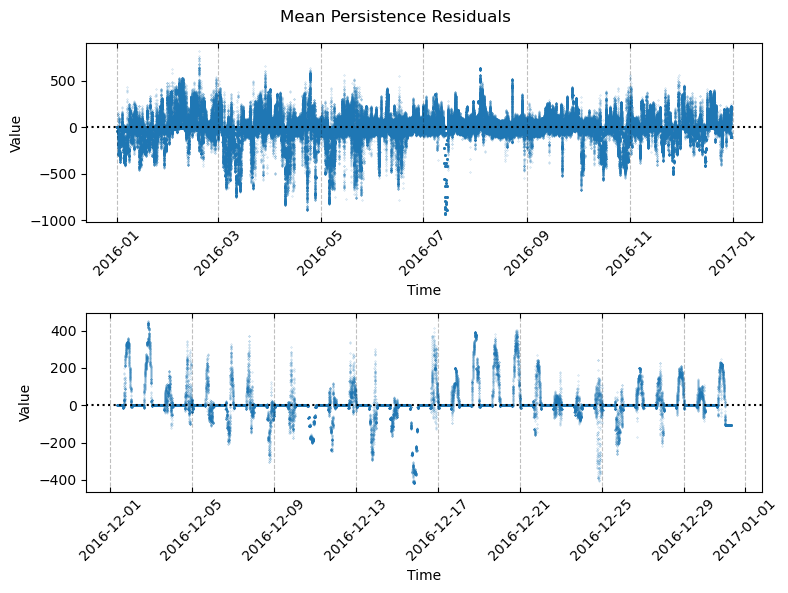

In [34]:
residual = outsample_forecast["ghi"] - outsample_forecast["ghi_forecast"]

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = visualize_time_series(
    ax=axs[0],
    time_series=residual,
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)
ax=visualize_time_series(
    axs[1],
    time_series=residual[-(60 * 24 * 30):],
    time_series_name="Residuals",
    s=0.05,
    alpha=0.5
)


for ax in axs:
    ax.axhline(
        y=0,
        linestyle=":",
        c="k"
    )

plt.suptitle("Mean Persistence Residuals")
plt.tight_layout()
plt.show()

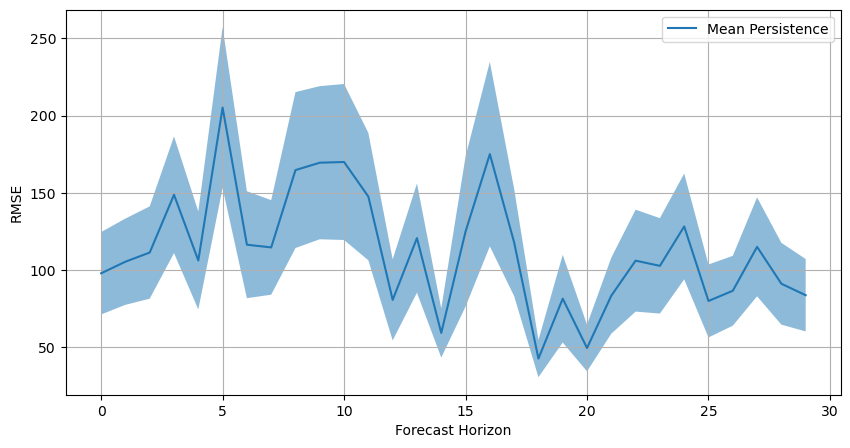

In [32]:
y_true = np.array(np.split(outsample_forecast["ghi"].values, 30)).T
y_forecast = np.array(np.split(outsample_forecast["ghi_forecast"].values, 30)).T

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Mean Persistence",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem
)
plt.legend()
plt.show()

## Baseline II - Exponential Moving Average

In [86]:
ground_truth = []
forecasts = []

from modules.models.baselines import ewm_forecast


for insample_indices, outsample_indices in tqdm(TIME_SERIES_SPLITTER.split(full_series)):

    insample_series, outsample_series = full_series[insample_indices], full_series[outsample_indices]
    ground_truth.append(outsample_series)

    insample_forecast, outsample_forecast = ewm_forecast(
        time_series=insample_series,
        steps_ahead=30,
        alpha=0.5,
    )
    forecasts.append(outsample_forecast)

ground_truth = np.array(ground_truth)
forecasts = np.array(forecasts)

  0%|          | 0/17535 [00:00<?, ?it/s]

  1%|          | 154/17535 [00:17<32:01,  9.04it/s]


KeyboardInterrupt: 

In [70]:
error_mean, error_sem = compute_rmse(
    y_true=ground_truth,
    y_forecast=forecasts,
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Exponential Moving Average",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem
)
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
daily_ghi_df = (
    insample_ghi_df
    .groupby(["year", "day_year"])["ghi"]
    .sum()
    .reset_index()
    .rename(
        {
            "ghi": "daily_ghi"
        },
    axis=1
    )
)

scaler_df = pd.merge(
    insample_ghi_df,
    daily_ghi_df,
    how="left",
    on=["year", "day_year",]
)

scaler_df["scaler_ghi"] = (scaler_df["ghi"] / scaler_df["daily_ghi"]).fillna(0)
scaler_df = scaler_df[["time", "month", "day_year", "hour", "year", "day_week", "minute", "ghi", "scaler_ghi"]]

scaler = StandardScaler()

y = scaler.fit_transform(daily_ghi_df["daily_ghi"].values.reshape(-1, 1)).flatten()
X = np.linspace(0, 1, len(y))

model = GaussianProcessRegressor()
model.fit(X.reshape(-1, 1), y)

daily_ghi_df["fitted_daily_ghi"] = scaler.inverse_transform(model.predict(X.reshape(-1, 1)).reshape(-1, 1)).flatten()
scaler_df = pd.merge(
    scaler_df,
    daily_ghi_df,
    on=["year", "day_year"],
    how="left"
)
scaler_df

In [38]:
import numpy as np
from jax import random

from sklearn.preprocessing import MinMaxScaler

from modules.data_handling.features_generators import make_fourier_matrix

from modules.models.jax_backend.additive_models import custom_ghi_model
from modules.models.jax_backend.initializers import random_gaussian
from modules.models.jax_backend.activation_functions import relu
from modules.models.jax_backend.losses import mae


ghi_scaler = MinMaxScaler()
satellite_covariates_scaler = MinMaxScaler()

y_insample = ghi_scaler.fit_transform(
    insample_ghi_df["ghi"].values.reshape(-1, 1)
).flatten()
y_outsample = ghi_scaler.transform(
    outsample_ghi_df["ghi"].values.reshape(-1, 1)
).flatten()

satellite_covariates = insample_ghi_df[np.arange(1, 101)].values
satellite_covariates = satellite_covariates_scaler.fit_transform(satellite_covariates)

master_key = random.PRNGKey(666)

insample_time = np.arange(len(y))
time_test = np.arange(time_train.max(), time_train.max() + len(y_out))

insample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=np.arange(len(y)), 
    n_components=10, 
    period=525949.2
)
insample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=np.arange(len(y)), 
    n_components=10, 
    period=1440
)

outsample_fourier_matrix_year_t = make_fourier_matrix(
    time_series_indices=time_test, 
    n_components=10, 
    period=525949.2
)
outsample_fourier_matrix_day_t = make_fourier_matrix(
    time_series_indices=time_test, 
    n_components=10, 
    period=1440
)



In [ ]:
init_params, forward, backward, get_components = custom_ghi_model(
    seasonality_init_method=random_gaussian,
    covariates_init_method=random_gaussian,
    mlp_hidden_link_function=relu,
    mlp_init_method=random_gaussian,
    mlp_layers=(1,),
    link_function=relu,
    loss_function=mae,
    covariates_reg_strength=0.0001,
    seasonality_reg_strength=0.0001,
    prngkey=random.split(master_key)[1]
)

start_params = init_params(
    insample_fourier_matrix_year, 
    insample_fourier_matrix_day,
    covariates=cov
)

In [39]:
from modules.models.jax_backend.fitters import fit
from modules.models.jax_backend.optimizers import newton_rhapson
from modules.models.jax_backend.callbacks import EarlyStopping



params, history = fit(
    X=(
        fourier_matrix_year,
        fourier_matrix_day,
        cov
    ),
    y=y, 
    backward=backward, 
    start_params=start_params, 
    optimizer=newton_rhapson(learning_rate=0.1),
    epochs=100, 
    stopper=EarlyStopping(tol=100), 
    verbose=1, 
    batch_size=None
)

Loss:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 0.16179999709129333: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


In [40]:
components_insample = get_components(
    (
        fourier_matrix_year,
        fourier_matrix_day,
        cov
    ),
    params,
    None
)

In [43]:
from modules.diagnostics.visualizers import visualize_time_series_components_performance

visualize_time_series_components_performance(
    time_series_train,
    time_series_test,
    components_insample,
    components_outsample,
    target_name,
    model_name,
    guardrail_metric,
    loss,
    history,
    figsize=(15, 5),
)

1.0

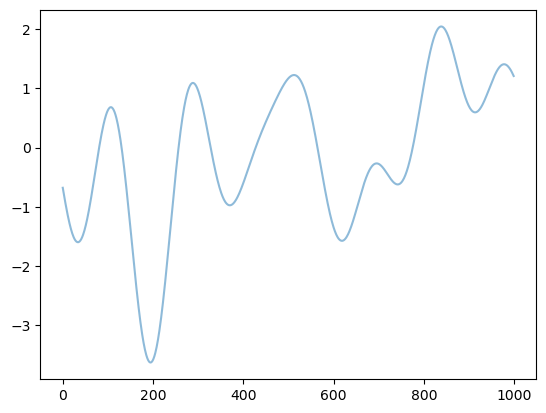

In [48]:

plt.plot(
    components_insample["daily_seasonality"][-1000:],
    alpha=0.5
)

## Inferential Approach I - Regularized Regression

In [28]:
import numpy as np

from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from modules.models.neural_networks.torch.architectures import LinearModel, MLPModel
from modules.models.neural_networks.torch.fitters import TorchModelFitter
from modules.models.neural_networks.torch.callbacks import EarlyStopping


model = MLPModel(
    10,
    2,
    (10, 10, 10),
    "ReLU",
    "ReLU",
    0.1
).to("cuda")

X = np.random.random(size=(10000, 10)).astype("float32")
y = np.random.random(size=(10000, 2)).astype("float32")
data = TensorDataset(
   Tensor(X).to("cuda"),
   Tensor(y).to("cuda"),
)
train_loader = DataLoader(
    data,
    batch_size=256,
    pin_memory=True
)
validation_loader = DataLoader(
    data,
    batch_size=256,
    pin_memory=True
)

stopper = EarlyStopping()
fitter = TorchModelFitter()
model, optimizer, hisotry = fitter.fit(
    model=model,
    optimizer=Adam(model.parameters()),
    train_loader=train_loader,
    validation_loader=validation_loader,
    stopper=stopper,
    epochs=1000,
    loss_function=MSELoss()

)

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned

## Inferential Approach II - MLP

## Inferential Approach III - RNN + MLP

## Inferential Approach IV - Custom Model

In [ ]:
import numpy as np
from jax import random

from modules.data_handling.features_generators import make_fourier_matrix


ghi_scaler = MinMaxScaler()
satellite_covariates_scaler = MinMaxScaler()

y_insample = ghi_scaler.fit_transform(
    insample_ghi_df["ghi"].values.reshape(-1, 1)
).flatten()
y_outsample = ghi_scaler.transform(
    outsample_ghi_df["ghi"].values.reshape(-1, 1)
).flatten()

satellite_covariates = insample_ghi_df[np.arange(1, 101)].values
satellite_covariates = satellite_covariates_scaler.fit_transform(satellite_covariates)

master_key = random.PRNGKey(666)

insample_time = np.arange(len(y))
time_test = np.arange(time_train.max(), time_train.max() + len(y_out))

insample_fourier_matrix_year = make_fourier_matrix(
    time_series_indices=np.arange(len(y)), 
    n_components=10, 
    period=525949.2
)
insample_fourier_matrix_day = make_fourier_matrix(
    time_series_indices=np.arange(len(y)), 
    n_components=10, 
    period=1440
)

outsample_fourier_matrix_year_t = make_fourier_matrix(
    time_series_indices=time_test, 
    n_components=10, 
    period=525949.2
)
outsample_fourier_matrix_day_t = make_fourier_matrix(
    time_series_indices=time_test, 
    n_components=10, 
    period=1440
)